# Исследование надежности заемщиков


Цель работы - исследование надежности заемщиков и влияния различных социальны аспектов на вероятность невозврата кредита


## Загрузка и анализ данных

In [1]:
import pandas as pd
from functools import lru_cache
from pymystem3 import Mystem
m = Mystem()
import seaborn as s

try:
    data = pd.read_csv('data.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/data.csv')

In [2]:
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


## Предобработка данных

### Удаление пропусков

In [4]:
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Пропуски в столбце с данными о доходах будут заполнены медианным значением для данной категории занятости

In [5]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['total_income'].isna()), 'total_income'] = \
    data.loc[(data['income_type'] == t), 'total_income'].median()

### Обработка аномальных значений

Отрицательные значения в графе с днями стажа - вероятно, опечатка, заменены на положительные

In [6]:
data['days_employed'] = data['days_employed'].abs()

In [7]:
data.groupby('income_type')['days_employed'].agg('median')

income_type
безработный        366413.652744
в декрете            3296.759962
госслужащий          2689.368353
компаньон            1547.382223
пенсионер          365213.306266
предприниматель       520.848083
сотрудник            1574.202821
студент               578.751554
Name: days_employed, dtype: float64

Обработка аномалий в столбце с количеством детей

In [8]:
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5], dtype=int64)

In [9]:
data = data[(data['children'] != -1) & (data['children'] != 20)]

In [10]:
data['children'].unique()

array([1, 0, 3, 2, 4, 5], dtype=int64)

заполнение пропусков в столбце `days_employed` медианными значениями для каждого типа занятости `income_type`

In [11]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['days_employed'].isna()), 'days_employed'] = \
    data.loc[(data['income_type'] == t), 'days_employed'].median()

Проверка отсутствия пропусков

In [12]:
data.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

### Изменение типов данных

In [13]:
data['total_income'] = data['total_income'].astype(int)

### Обработка дубликатов

In [14]:
data['education'] = data['education'].str.lower()

In [15]:
data.duplicated().sum()

71

In [16]:
data = data.drop_duplicates()

### Категоризация данных

На основании диапазонов, указанных ниже, создан столбец `total_income_category` с категориями дохода:

- 0–30000 — `'E'`;
- 30001–50000 — `'D'`;
- 50001–200000 — `'C'`;
- 200001–1000000 — `'B'`;
- 1000001 и выше — `'A'`.

In [17]:
def categorize_income(income):
    try:
        if 0 <= income <= 30000:
            return 'E'
        elif 30001 <= income <= 50000:
            return 'D'
        elif 50001 <= income <= 200000:
            return 'C'
        elif 200001 <= income <= 1000000:
            return 'B'
        elif income >= 1000001:
            return 'A'
    except:
        pass

In [18]:
data['total_income_category'] = data['total_income'].apply(categorize_income)

Уникальные цели взятия кредита для их последующей категоризации

In [19]:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Функция для категоризации цели кредита

In [20]:
@lru_cache(maxsize=50000)
def categorize_purpose(string):
    purp = m.lemmatize(string)
    if 'автомобиль' in purp:
        return('операции с автомобилем')
    elif 'недвижимость' in purp or 'жилье' in purp:
        return('операции с недвижимостью')
    elif 'свадьба' in purp:
        return('проведение свадьбы')
    elif 'образование' in purp:
        return('получение образования')
    else:
        return('unknown_category')

In [21]:
data['purpose_category'] = data['purpose'].apply(categorize_purpose)

### Исследование данных

#### Есть ли зависимость между количеством детей и возвратом кредита в срок?

In [22]:
data_grouped_children = data.groupby('children').agg({'debt':['count', 'sum']})
data_grouped_children['default_risk'] = data_grouped_children['debt']['sum'] / data_grouped_children['debt']['count']

#это только для построения графика
data_grouped_children['children'] = data.sort_values(by='children')['children'].unique()
print(data_grouped_children)

           debt       default_risk children
          count   sum                      
children                                   
0         14091  1063     0.075438        0
1          4808   444     0.092346        1
2          2052   194     0.094542        2
3           330    27     0.081818        3
4            41     4     0.097561        4
5             9     0     0.000000        5


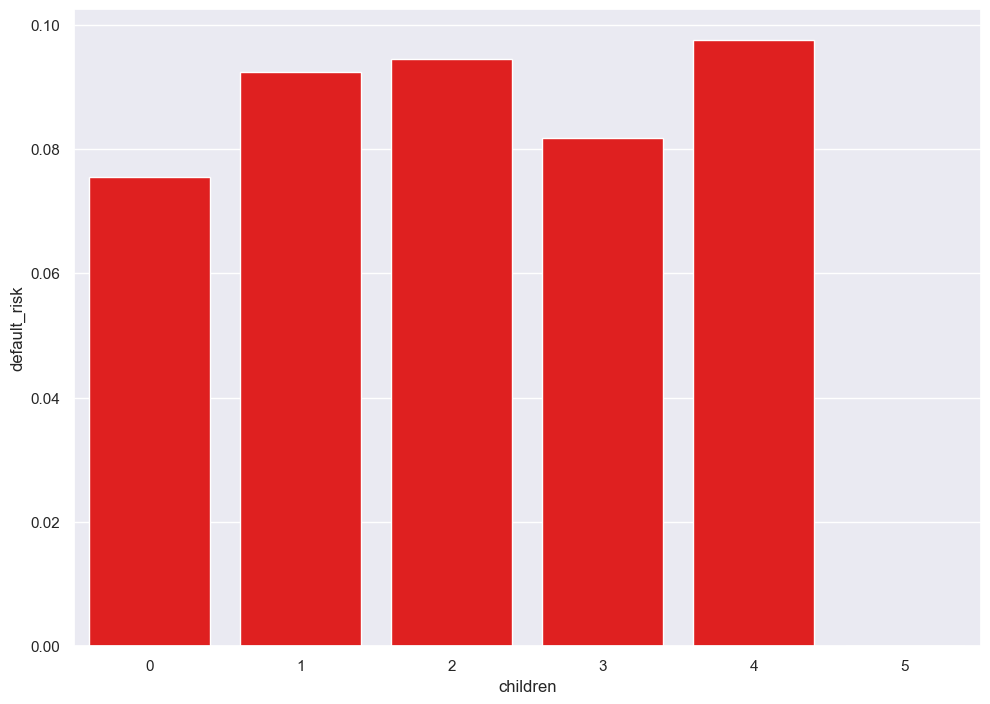

In [23]:
s.set(rc={'figure.figsize':(11.7,8.27)})
s.barplot(x=data_grouped_children['children'], y=data_grouped_children['default_risk'], color='red');

1. Наличие детей увеличивает риск просрочки по кредиту приблизительно на 25%.
2. Рост количества детей не влияет на риск просрочки по кредиту: результаты для заемщиков с 4 и 5 детьми не представительны, поскольку выборка крайне мала по сравнению с общей совокупностью заемщиков. Также представляется сомнительной гипотеза о том, что после третьего ребенка заемщики становятся более ответственными: доля таких заемщиков в общей совокупности около 1%, поэтому результат может также быть обусловен аномалиями.

**Вывод:** 
Наличие 1 или 2 детей должно учитываться при расчете скоринга. Большее количество детей должно приниматься во внимание, но не должно использоваться при автоматическом расчете скоринга: решение по многодетным семьям должно приниматься индивидуально.

####  Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [24]:
data_grouped_family = data.groupby('family_status').agg({'debt':['count', 'sum']})
data_grouped_family['default_risk'] = data_grouped_family['debt']['sum'] / data_grouped_family['debt']['count']
print(data_grouped_family)

                        debt      default_risk
                       count  sum             
family_status                                 
Не женат / не замужем   2796  273     0.097639
в разводе               1189   84     0.070648
вдовец / вдова           951   63     0.066246
гражданский брак        4134  385     0.093130
женат / замужем        12261  927     0.075606


Интересно, но выводы делать пока рано. Кажется, что разделение на группы "не женат/не замужем" и "гражданский брак" не вполне корректно. Если человек свои отношения с партнером не оформил официально, то на вопрос банка с равной вероятностью может быть дан как ответ "не женат", так и ответ "гражданский брак". Поэтому, кажется, надо объединить эти 2 категории и посмотреть на зависимость еще раз.

Количество заемщиков в статусе женат / замужем - 12261 из них должников 927 -     7.6%
Количество заемщиков в статусе гражданский брак - 4134 из них должников 385 -     9.3%
Количество заемщиков в статусе вдовец / вдова - 951 из них должников 63 -     6.6%
Количество заемщиков в статусе в разводе - 1189 из них должников 84 -     7.1%
Количество заемщиков в статусе Не женат / не замужем - 2796 из них должников 273 -     9.8%


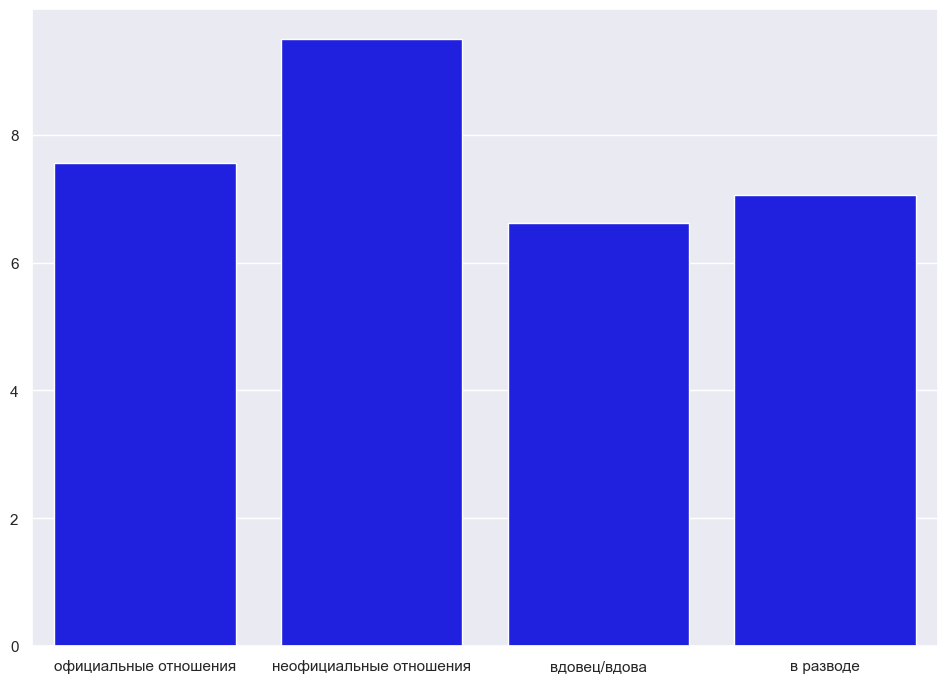

In [26]:
percentage_m = []
for status in data['family_status'].unique():
    borrowers = data.loc[data["family_status"] == status]["family_status"].count()
    debtors = data.loc[(data["debt"] == 1) & (data["family_status"] == status)]["debt"].sum()
    print(f'Количество заемщиков в статусе {status} - {borrowers} из них должников {debtors} - \
    {(debtors / borrowers):.01%}')
    percentage_m.append(debtors / borrowers * 100)


status_m = ['официальные отношения', 'неофициальные отношения', 'вдовец/вдова', 'в разводе']
percentage_m[1] = 100 * data.loc[(data["debt"] == 1) & ((data["family_status"] == 'гражданский брак') \
    | (data["family_status"] == 'Не женат / не замужем'))]["debt"].sum() / \
    data.loc[(data["family_status"] == 'гражданский брак') | (data["family_status"] == 'Не женат / не замужем')]["family_status"].count()
percentage_m.pop()

s.set(rc={'figure.figsize':(11.7,8.27)})
s.barplot(x = status_m, y = percentage_m, color='blue');

**Вывод:** 
Что же, первоначальная гипотеза, основанная на стереотипах, что штамп в паспорте означает повышенную ответственность, подтвердилась. **Отсутствие официальных отношений (в настоящем или в прошлом) повышает риск невозврата кредита в срок.**
Что же касается вдовцов и вдов, то стоит вспомнить, что общее их количество менее 5% от всей выборки. Поэтому для вывода "*серьезное травмирующее переживание в прошлом повышает ответственность*" недостаточно данных.

#### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [27]:
data['total_income_category'].unique()

array(['B', 'C', 'D', 'E', 'A'], dtype=object)

In [28]:
data_grouped_income = data.groupby('total_income_category').agg({'debt':['count', 'sum']})
data_grouped_income['default_risk'] = data_grouped_income['debt']['sum'] / data_grouped_income['debt']['count']
print(data_grouped_income)

                        debt       default_risk
                       count   sum             
total_income_category                          
A                         25     2     0.080000
B                       5014   354     0.070602
C                      15921  1353     0.084982
D                        349    21     0.060172
E                         22     2     0.090909


**Вывод:** 
Неплохо так, да?
По этим данным вообще сложно что-то сказать, кроме того, что риск невозврата кредита, независимо от уровня дохода, составляет около 7-8%. Слишком малы все категории заемщиков, кроме B и C. Однако, есть предположение, что надо рассматривать этот вопрос в комплексе с целью займа, а значит, и с размером кредита. Проверим. 

#### Как разные цели кредита влияют на его возврат в срок?

In [29]:
data_grouped_purpose = data.groupby('purpose_category').agg({'debt':['count', 'sum']})
data_grouped_purpose['default_risk'] = data_grouped_purpose['debt']['sum'] / data_grouped_purpose['debt']['count']
print(data_grouped_purpose)

                           debt      default_risk
                          count  sum             
purpose_category                                 
операции с автомобилем     4279  400     0.093480
операции с недвижимостью  10751  780     0.072551
получение образования      3988  369     0.092528
проведение свадьбы         2313  183     0.079118


Пока что подтверждается предположение, что **жилищные кредиты более безопасны с точки зрения возврата в срок**. Однако, попробуем разделить категории по ожидаемой величине кредита. Так, свадьбы попадут в категорию "малые кредиты", автомобиль и образование - "средние", недвижимость - "крупные".

In [30]:
def categorize_size(purpose):
    if purpose == 'операции с недвижимостью':
        return(2)
    elif purpose == 'проведение свадьбы':
        return(1.5)
    else:
        return(1)
data['category_size'] = data['purpose_category'].apply(categorize_size)


#преобразуем класс дохода в число:

def income_class(income):
    return 1 - (ord(income) - ord('A')) * .1

# И соберем из размера категории, класса дохода и наличия просрочки по кредиту новый датафрейм

data_1 = pd.DataFrame({"income_class" : data['total_income_category'].apply(income_class),
                      "purpose_class" : data['category_size'],
                      "debt" : data['debt']})

#относительная величина кредита
data_1['relative_debt'] = round(data_1['income_class'] / data_1['purpose_class'], 2)
        
data_1.head()

,income_class,purpose_class,debt,relative_debt
0,0.9,2.0,0,0.45
1,0.8,1.0,0,0.80
2,0.8,2.0,0,0.40
3,0.9,1.0,0,0.90
4,0.8,1.5,0,0.53


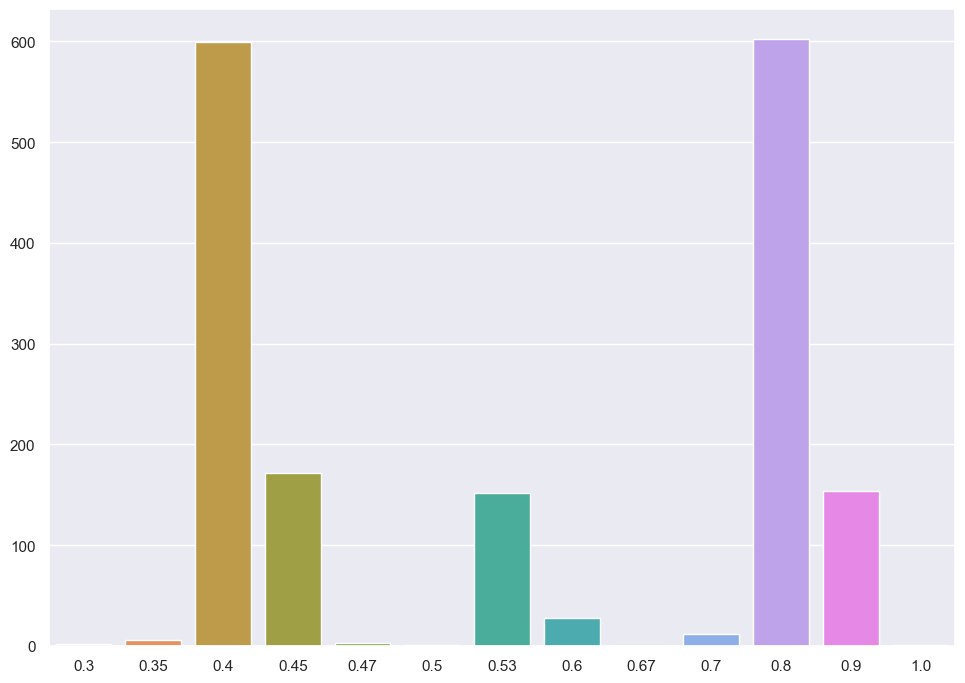

In [31]:
# И визуализируем
debts = []
for rel in data_1['relative_debt'].unique():
    debts.append(data_1.loc[(data_1["debt"] == 1) & (data_1["relative_debt"] == rel)]["debt"].sum())

s.set(rc={'figure.figsize':(11.7,8.27)})
s.barplot(x=data_1['relative_debt'].unique(), y=debts);

**Вывод:** 
Видно, что наиболее часто люди допускают просрочки по кредитам следующих типов:
- Кредит с большой относительно дохода суммой (вероятная причина - проблемы с платежеспособностью)
- Кредит с малой относительно дохода суммой (вероятная причина - безответственное отношение)

#### Возможные причины появления пропусков в исходных данных.

Безусловно, можно было бы списать пропуски на технические причины или человеческий фактор при заполнении данных. Однако, если посмотреть, что пропуски есть только в столбцах "доход" и "количество дней трудового стажа", при этом, пропусков и там, и там одинаковое количество, можно с большой долей уверенности сказать, что это люди, имеющие такой источник дохода, **подтвердить который они или не могут, или не хотят**

In [33]:
#чтобы проверить эту гипотезу - вернемся к исходному датасету и посмотрим, у каких категорий людей пропущены стаж и доход
data_missed = pd.read_csv('data.csv')
data_missed = data_missed.loc[(data_missed['total_income'].isna()) & (data_missed['days_employed'].isna())]
data_missed.groupby('income_type')['income_type'].count()

income_type
госслужащий         147
компаньон           508
пенсионер           413
предприниматель       1
сотрудник          1105
Name: income_type, dtype: int64

#### Обоснование, почему заполнить пропуски медианным значением — лучшее решение для количественных переменных.

В данном случае - заполнить пропуски медианным значением не самая хорошая идея, поскольку, вероятнее всего, возникновение пропусков не случайно. То есть за пропущенными значениями мог скрываться как очень большой неофициальный доход, так и очень малый. А пропуски составляли, на минуточку, 10% от выборки, так что, на распределение заемщиков по категориям дохода это могло повлиять заметно. Другой вопрос, что **заполнение медианным значением лучшее из всех возможных, потому что остальные еще хуже.** Так, заполнение средним арифметическим исказило бы выборку, поскольку среднее арифметическое очень чувствительно к выбросам значений, а заполнить модой - означало быть раздуть категорию "среднего класса" до размеров почти что всей выборки.

## Общий вывод.


<b>Методика исследования</b>
    
В ходе исследования для оценки влияния различных жизненных обстоятельств заемщика на риск просрочки платежей по кредиту определялась доля заемщиков с просрочкой среди всех заемщиков выбранной категории.
    
<b>Основные результаты<b>


1. Наличие 1-2 детей в семье повышает приблизительно на 25% риск просрочки по кредиту.
2. К многодетным семьям нужен индивидуальный подход.
3. Наличие официально зарегистрированных отношений снижает риск просрочки по кредиту.
4. Уровень дохода практически не влияет на просрочки по кредиту.
5. Кредиты на жилье люди выплачивают аккуратнее и допускают меньше просрочек.
6. Люди допускают просрочки либо по большим, либо по малым относительно своего дохода кредитам.
7. Заполнение пропусков медианным значением может быть не лучшей идеей, если пропуски не случайны. Как возможный вариант - исключить такие строки из датасета, рассматривать исходный и модифицированный датасет как различные, а затем сравнить.
8. Кто я такой, чтобы делать выводы про 147 госслужащих, которые постеснялись сообщать свой доход... ;)